<font color="blue" face="Verdana" size="20">Energy Consumption Forecasting using a Hybrid CNN-RNN Model</font>

<font color="blue" face="Verdana" size=10> With</font>

<font size = 25 color = "Blue"> Energy Consumption Time Series Dataset </font>

<font color="green" face="Verdana" size="4">1. Load Data</font>

In [2]:
# from os import listdir
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

from os import listdir
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import Huber  # Import Huber loss
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data_files = [file for file in listdir('.') if file.endswith('.csv')] 




<font color="green" face="Verdana" size="4">2. Data Preprocessing</font>

In [3]:
data_list = []
for file in data_files:
    df = pd.read_csv(file)
    df.columns = ['Index', 'TxnDate', 'TxnTime', 'Consumption']
    data_list.append(df[['TxnDate', 'TxnTime', 'Consumption']])

data = pd.concat(data_list, ignore_index=True)
data.info()
# Converted 'TxnDate' and 'TxnTime' to datetime and set as index
data['Datetime'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'], format='%d-%b-%y %H:%M:%S')
data = data[['Datetime', 'Consumption']].set_index('Datetime')

data = data.sort_index()

# Added Lag Features
for lag in range(1, 8):
    data[f'lag_{lag}'] = data['Consumption'].shift(lag)

# Added Rolling Features
data['rolling_mean'] = data['Consumption'].rolling(window=7).mean()
data['rolling_std'] = data['Consumption'].rolling(window=7).std()
data['rolling_median'] = data['Consumption'].rolling(window=7).median()

# Exponential Moving Average (EMA)
data['ema'] = data['Consumption'].ewm(span=7, adjust=False).mean()



# 4. Trend/Seasonality Decomposition
decomposition = seasonal_decompose(data['Consumption'].ffill(), model='additive', period=7)
data['trend'] = decomposition.trend.ffill()
data['seasonal'] = decomposition.seasonal.ffill()
data['residual'] = decomposition.resid.ffill()





# # Trend/Seasonality Decomposition 
# decomposition = seasonal_decompose(data['Consumption'].ffill(), model='additive', period=7)
# data['trend'] = decomposition.trend.ffill()
# # data['seasonal'] = decomposition.seasonal.ffill()
# data['residual'] = decomposition.resid.ffill()

# Droped NaN values
data.dropna(inplace=True)

# Saved the preprocessed data into a CSV file
data.to_csv('Saved/preprocessed_data.csv')
print("Preprocessed data has been saved to 'preprocessed_data.csv'.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606 entries, 0 to 3605
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TxnDate      3606 non-null   object 
 1   TxnTime      3606 non-null   object 
 2   Consumption  3606 non-null   float64
dtypes: float64(1), object(2)
memory usage: 84.6+ KB
Preprocessed data has been saved to 'preprocessed_data.csv'.


<font color="green" face="Verdana" size="4">2. Visualizing Daily Consumption</font>

Plot saved as Saved/Consumption_Daily.png


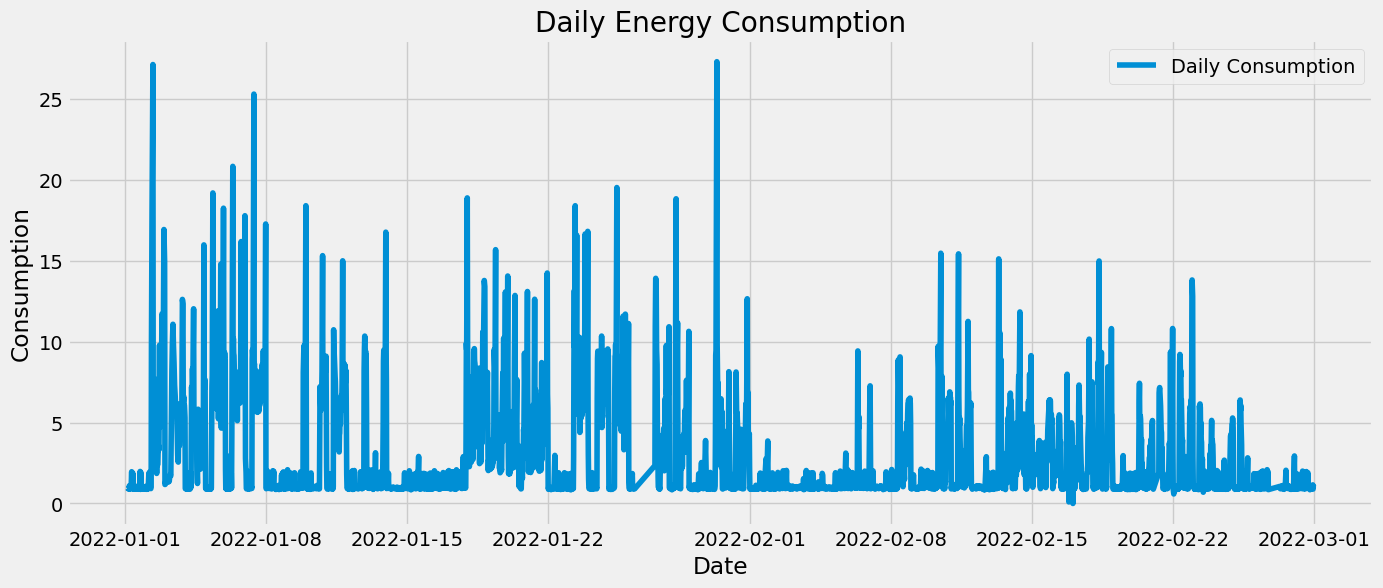

In [4]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Consumption'], label='Daily Consumption')
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Daily Energy Consumption")
plt.legend()
plt.grid(True)
plt.draw()
output_path = 'Saved/Consumption_Daily.png' 
plt.savefig(output_path, dpi=300, bbox_inches='tight')  
print(f"Plot saved as {output_path}")
plt.show()

<font color="green" face="Verdana" size="4">3. Normalize the Data</font>

In [ ]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# data['Consumption'] = scaler.fit_transform(data[['Consumption']])
# data.info()

<font color="green" face="Verdana" size="4">4. Plot Distribution of Normalized Data</font>

Plot saved as Saved/Distribution.png


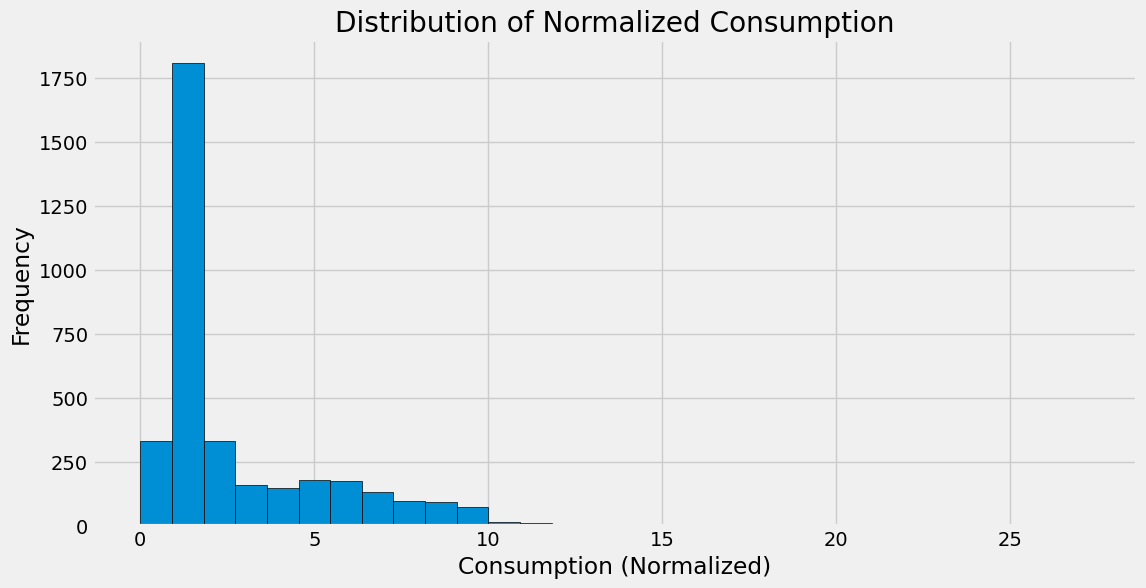

In [5]:
plt.figure(figsize=(12, 6))
plt.hist(data['Consumption'], bins=30, edgecolor='black')
plt.xlabel('Consumption (Normalized)')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Consumption')

# Render and save the plot
plt.draw()  # Render the plot before saving
output_path = 'Saved/Distribution.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save the plot with high resolution
print(f"Plot saved as {output_path}")

plt.show()

<font color="green" face="Verdana" size="4">5. Creating Input-Output Pairs with Windowing</font>

In [ ]:
# def create_sequences(data, window_size):
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         X.append(data[i:i + window_size])
#         y.append(data[i + window_size])
#     return np.array(X), np.array(y)

# window_size = 40
# X, y = create_sequences(data['Consumption'].values, window_size)
# X = X.reshape(X.shape[0], X.shape[1], 1)


<font color="green" face="Verdana" size="4">6. Split the Data into Training, Validation, and Test Sets</font>

In [ ]:
# train_size = int(len(X) * 0.7)
# val_size = int(len(X) * 0.2)
# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
# X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [6]:

# Train/Val/Test Split (before scaling to avoid leakage)
train = data.iloc[:int(len(data)*0.7)]
val = data.iloc[int(len(data)*0.7):int(len(data)*0.9)]
test = data.iloc[int(len(data)*0.9):]

# Scale data using training statistics
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

# Sequence Creation
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])  # Assuming Consumption is first column
    return np.array(X), np.array(y)

window_size = 40
X_train, y_train = create_sequences(train_scaled, window_size)
X_val, y_val = create_sequences(val_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

<font color="green" face="Verdana" size="4">7. Building the Hybrid CNN-RNN Model</font>


In [7]:
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),  # Match number of features
    Conv1D(64, 3, activation='relu', dilation_rate=2),
    Conv1D(64, 3, activation='relu', dilation_rate=4),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(optimizer=AdamW(learning_rate=1e-3),
              loss=Huber(),  # Use Huber loss class
              metrics=['mae', 'mse'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_schedule]
)


# model = Sequential([
#     Input(shape=(window_size, 1)),
#     Conv1D(filters=32, kernel_size=3, activation='relu', dilation_rate=4),
#     Dropout(0.2),
#     BatchNormalization(),
#     LSTM(50, return_sequences=False),
#     Dense(1)
# ])

# model.compile(optimizer='AdamW', loss='mae')
# model.summary()





Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0058 - mae: 0.0727 - mse: 0.0116 - val_loss: 0.0030 - val_mae: 0.0578 - val_mse: 0.0060 - learning_rate: 0.0010
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0029 - mae: 0.0479 - mse: 0.0058 - val_loss: 0.0035 - val_mae: 0.0548 - val_mse: 0.0070 - learning_rate: 0.0010
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0021 - mae: 0.0400 - mse: 0.0042 - val_loss: 0.0029 - val_mae: 0.0510 - val_mse: 0.0059 - learning_rate: 0.0010
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0014 - mae: 0.0329 - mse: 0.0029 - val_loss: 0.0024 - val_mae: 0.0472 - val_mse: 0.0048 - learning_rate: 0.0010
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0019 - mae: 0.0350 - mse: 0.0037 - val_loss: 0.0017 - val_mae: 0.0373 - val_mse: 0.0034 - learning_rate: 0.0010
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0014 - mae: 0.0310 - mse: 0.0028 - val_loss: 0.0015 - val_mae: 0.0354 - va

<font color="green" face="Verdana" size="4">8. Training the Model</font>

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=50,
#     batch_size=32,
#     callbacks=[early_stopping]
# )


<font color="green" face="Verdana" size="4">9. Evaluating the Model</font>

In [8]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE (Normalized): {rmse:.4f}')
print(f'MAE (Normalized): {mae:.4f}')

y_pred_original_scale = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse_original = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
mae_original = mean_absolute_error(y_test_original_scale, y_pred_original_scale)

print(f'RMSE (Original Scale): {rmse_original:.4f}')
print(f'MAE (Original Scale): {mae_original:.4f}')

r2 = r2_score(y_test_original_scale, y_pred_original_scale)
print(f'R-squared (R2): {r2:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
RMSE (Normalized): 0.0166
MAE (Normalized): 0.0092


ValueError: non-broadcastable output operand with shape (320,1) doesn't match the broadcast shape (320,15)

<font color="green" face="Verdana" size="4">10. Visualizing Training History</font>

Plot saved as Saved/model_training_history.png


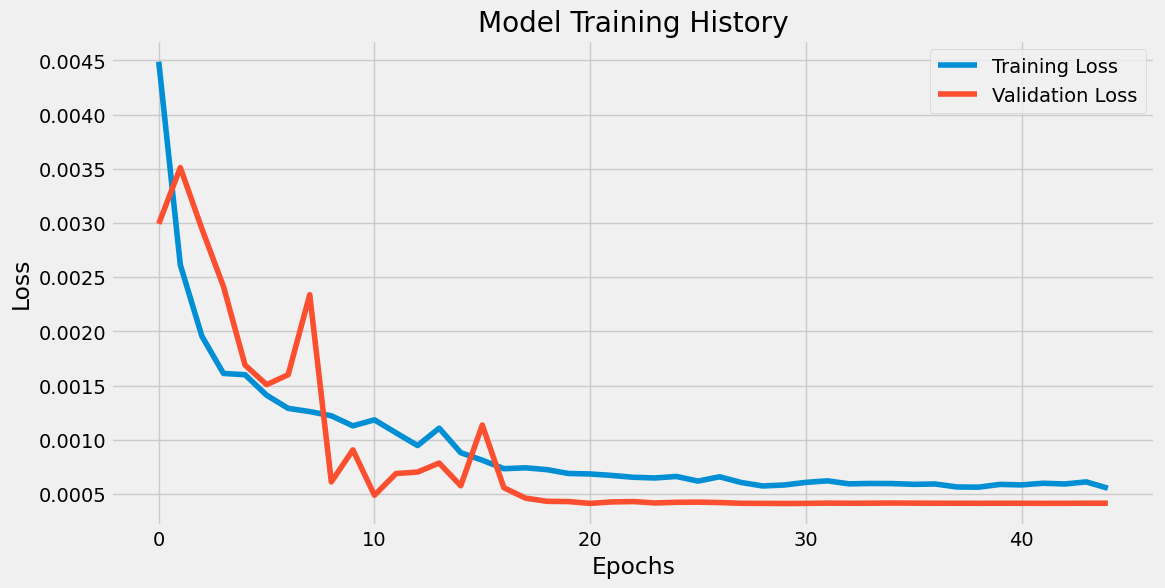

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.draw()  
output_path = 'Saved/model_training_history.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  
print(f"Plot saved as {output_path}")

plt.show()

<font color="green" face="Verdana" size="4">11. Visualizing Predictions</font>

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original_scale, label='Actual', color='blue')
plt.plot(y_pred_original_scale, label='Predicted', color='orange')
plt.title('Actual vs Predicted Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.grid(True)

plt.draw()  
output_path = 'Saved/actual_vs_pred.png'

plt.savefig(output_path, dpi=300, bbox_inches='tight')  
print(f"Plot saved as {output_path}")

plt.show() 

NameError: name 'y_test_original_scale' is not defined

<Figure size 1200x600 with 0 Axes>

<font color="green" face="Verdana" size="4">12. Save the Model</font>

In [ ]:
model.save('Saved/hybrid_cnn_rnn_model.keras')
